# Bictoin trading experiments

## Module imports

In [323]:
import pandas as pd
import random
import numpy as np
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import math


## Base trader class
This is the class from which trader objects can be instantiated.
Each trader is istantiated with a certain amount of USD.
At any given time, traders can either purchase or purchase BTC for a rate passed as parameter

In [324]:
class Trader:
    
    # Constructor
    def __init__(self, initial_usd):
        self.available_usd = initial_usd
        self.available_btc = 0
    
    # Computed property: wealth
    def wealth(self, exchange_rate):
        return self.available_usd + exchange_rate * self.available_btc
    
    # Basic operations: sell and buy
    def sell_usd(self, usd_amount_to_sell, exchange_rate):
        # Buy BTC with USD
        
        # Prevent selling more than available
        if usd_amount_to_sell > self.available_usd:
            print('Amount exceeds available assets')
            return
                
        purchased_btc = usd_amount_to_sell / exchange_rate
         
        self.available_btc += purchased_btc
        self.available_usd -= usd_amount_to_sell
                
    def sell_btc(self, btc_amount_to_sell, exchange_rate):
        # Buy USD with BTC
        
        # Prevent selling more than available
        if btc_amount_to_sell > self.available_btc:
            print('Amount exceeds available assets')
            return
        
        purchased_usd = btc_amount_to_sell * exchange_rate
        
        self.available_usd += purchased_usd
        self.available_btc -= btc_amount_to_sell
    
    def buy_btc(self, btc_amount_to_buy, exchange_rate):
        # Alias for "sell_usd" but with BTC amount as parameter
        usd_amount_to_sell = btc_amount_to_buy * exchange_rate
        self.sell_usd(usd_amount_to_sell, exchange_rate)
    
    def buy_btc(self, usd_amount_to_buy, exchange_rate):
        # Alias for "sell_btc" but with USD amount as parameter
        btc_amount_to_sell = usd_amount_to_buy / exchange_rate
        self.sell_btc(buy_btc, exchange_rate)
            
    
    # Trade strategies
    def random_trade(self, exchange_rate):
        
        # -1: sell all BTC
        # 0: do nothing
        # 1: exchange all USD to BTC (buy as much BTC as possible)

        # (USD to sell, BTC to sell)
    
        probability = random.uniform(-1, 1)
        
    
        if probability > 0 :
            # Sell a certain amount of USD
            interpolation = interp1d([0,1],[0,self.available_usd])
            usd_to_sell = float(interpolation(probability))
            self.sell_usd(usd_to_sell, exchange_rate)

        if probability < 0 :
            # Sell a certain amount of BTC
            interpolation = interp1d([-1,0],[self.available_btc,0])
            btc_to_sell = float(interpolation(probability))
            self.sell_btc(btc_to_sell, exchange_rate)

## Traders with strategies
A basic trader can perform trading operations but has no strategy.
Trading strategies are defined in sublasses

### Random trader
This trader just buys and sells BTC randomly

In [325]:
class RandomTrader(Trader):
    
    # Constructor
    def __init__(self, initial_usd):
        super().__init__(initial_usd)
    
    # Trade strategy
    def trade(self, exchange_rate):
        
        # -1: sell all BTC
        # 0: do nothing
        # 1: exchange all USD to BTC (buy as much BTC as possible)

        # (USD to sell, BTC to sell)
    
        probability = random.uniform(-1, 1)
        
    
        if probability > 0 :
            # Sell a certain amount of USD
            interpolation = interp1d([0,1],[0,self.available_usd])
            usd_to_sell = float(interpolation(probability))
            self.sell_usd(usd_to_sell, exchange_rate)

        if probability < 0 :
            # Sell a certain amount of BTC
            interpolation = interp1d([-1,0],[self.available_btc,0])
            btc_to_sell = float(interpolation(probability))
            self.sell_btc(btc_to_sell, exchange_rate)

## Data import
Importing .csv file of the BTC price from 2012 to 2020 into a pandas dataframe

In [326]:
FILE_NAME = "bitstampUSD_1-min_data_2012-01-01_to_2020-09-14.csv"

In [327]:
btc_data = pd.read_csv(FILE_NAME)

#limit to mid 2020 - present
START_TIMESTAMP = 1575082800 #JAN 2020
#START_TIMESTAMP = 1588294861
#START_TIMESTAMP = 1598294861
btc_data = btc_data[btc_data.Timestamp > START_TIMESTAMP]

# Only take the Open column
btc_data = btc_data.Open

# Drop the NaN
btc_data = btc_data.dropna()

# Convert to numpy
btc_data = btc_data.to_numpy()

In [328]:
btc_data.shape

(408893,)

## Experiment
Test with a random trader

In [329]:
# Instanciate a random trader object with USD 1000
random_trader = RandomTrader(1000)

wealth_history = []
for exchange_rate in btc_data[0:1000]:
    
    random_trader.trade(exchange_rate)
    
    # Save the wealth at each iteration
    wealth_history.append(random_trader.wealth(exchange_rate))
    
    
print('Final wealth: {}, USD: {}, BTC: {}'.format(
    random_trader.wealth(exchange_rate), 
    random_trader.available_usd, 
    random_trader.available_btc))



Final wealth: 985.8021410430324, USD: 299.101563313722, BTC: 0.09156007703057473


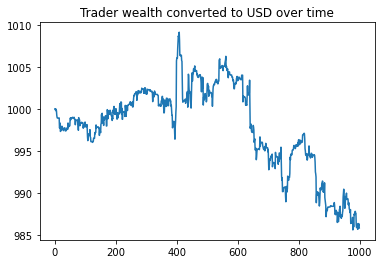

In [330]:
plt.plot(wealth_history)
plt.title("Trader wealth converted to USD over time")
plt.show()

## Evolution strategies

In [331]:
class Chromosome:
    
    # Constructor
    def __init__(self, genes_size, spread=1.0, mutation_scale=1.0):
        
        # Initialize genes randomly
        self.genes = np.random.uniform(low=-spread, high=spread, size=genes_size)
        
        # Chromosome is initally alive with undefined fitness
        self.alive = True
        self.fitness = 0
        
        # Storing the mutation scale
        self.mutation_scale = mutation_scale
        
    
    def born_from (self, parent):
        # Chromosome has genes similar to its parents', but slightly mutated
        
        # Todo: adjust mu and sigma
        # Especially sigma because new genes centered around parent genes
        self.genes = parent.genes + np.random.normal(scale=self.mutation_scale, size=parent.genes.shape)
        
        # Child is now alive again
        self.alive = True
        
        # there would be other ways to modify a child's genes like crossover but for now this is good enough

In [332]:
class Population:
    
    # Constructor
    def __init__(self, population_size, genes_size, fitness_function=None, spread=1.0, mutation_scale=1.0):
        
        # Instanciate chromosomes of the population
        self.chromosomes = [Chromosome(genes_size, spread=spread, mutation_scale=mutation_scale) for c in range(population_size)]
        
        # Store the fitness function if given
        self.fitness_function = fitness_function
        
        
    def fitness_of_population(self):
        # Computes the fitness of each chromosome using the provided fitness function
        for chromosome in self.chromosomes:
            chromosome.fitness = self.fitness_function(chromosome.genes)
    
    def best_chromosome(self):
        # Gets the chromosome with the best fitness.
        # Used to retrieve results after evolution
        return max(self.chromosomes, key=lambda x: x.fitness)
    
    def survival_of_the_fittest(self):
        
        # A chromosome's survival probability depends on how it compares to others
        # Hence, one needs to know the range of fitness the population is currently in
        self.min_fitness = min(self.chromosomes, key=lambda x: x.fitness).fitness
        self.max_fitness = max(self.chromosomes, key=lambda x: x.fitness).fitness
        
        for chromosome in self.chromosomes:
            
            if self.min_fitness < self.max_fitness:
                
                # Putting some luck in the mix
                # Here, using > and not >= to ensure at least one chromosome stays alive
                if random.uniform(self.min_fitness,self.max_fitness) > chromosome.fitness :
                    chromosome.alive = False
            
            # Deal with the edge case of having all fitnesses the same
            else :
                if random.uniform(0,1) > 0.5 :
                    chromosome.alive = False
                    
    
    def offspring_of_the_fittest(self):
        # Replacing dead chromosomes with offspring of the survivors
        
        live_chromosomes = [c for c in self.chromosomes if c.alive]
        dead_chromosomes = [c for c in self.chromosomes if not c.alive]
        
        for chromosome in dead_chromosomes:
            
            if not chromosome.alive:
                # Take a random parent from the survivors
                parent = random.choice(live_chromosomes)
                
                # Generate offspring
                chromosome.born_from(parent)
                
                
    def evolve(self, generations):
        
        for generation in range(generations):
            self.fitness_of_population()
            self.survival_of_the_fittest()
            self.offspring_of_the_fittest()
            print('Generation: {}, max_fitness: {}'.format(generation,self.max_fitness))

In [333]:
class EvolvedTrader(Trader):
    
    # Constructor
    def __init__(self, initial_usd, genes):
        super().__init__(initial_usd)
        
        self.genes = genes
    
    # Helper functions
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    # Trade strategy
    def trade(self, exchange_rate, decision_inputs):
        
        # Compute difference of inputs to current exchange rate
        decision_deltas = np.full(decision_inputs.shape, exchange_rate) - decision_inputs

        
        scalar_product = np.dot(decision_deltas,self.genes)
        
        probability = 2.0*self.sigmoid(scalar_product) -1.0
        
        # Could be simplified with a mapping
        
        if probability > 0 :
            # Sell a certain amount of USD
            interpolation = interp1d([0,1],[0,self.available_usd])
            usd_to_sell = float(interpolation(probability))
            self.sell_usd(usd_to_sell, exchange_rate)

        if probability < 0 :
            # Sell a certain amount of BTC
            interpolation = interp1d([-1,0],[self.available_btc,0])
            btc_to_sell = float(interpolation(probability))
            self.sell_btc(btc_to_sell, exchange_rate)

### Fitness function
A Trader has a certain set of genes that influence his trade decisions.
The objective is to evolve a population of traders so that their ability to generate wealth is maximized.
Hence, the fitness function of a trader is the amount of wealth generated within a given dataset

In [334]:
def fitness_function(genes):
    
    # Instantiate a trader with the genes from the given chromosome
    trader = EvolvedTrader(1000, genes)
    
    start_index = 100
    length = 1000
    
    for i, exchange_rate in enumerate(btc_data[start_index:start_index+length]):
        
        decision_inputs = btc_data[start_index+i-genes.shape[0]:start_index+i]
        trader.trade(exchange_rate, decision_inputs)
    
    # After a run of trade, the fitness function is the amount of wealth accumulated
    return trader.wealth(exchange_rate)
        

### Population
Create a population of traders initialized with random genes

In [335]:
decision_input_length = 50

trader_population = Population(
    50, 
    (decision_input_length,), 
    fitness_function, 
    spread=0.1, 
    mutation_scale=0.1
)

Perform natural selection on the population of traders

In [336]:
trader_population.evolve(50)

Generation: 0, max_fitness: 1015.1902994469149
Generation: 1, max_fitness: 1020.8127811665166
Generation: 2, max_fitness: 1024.319020500699
Generation: 3, max_fitness: 1024.6467427673376
Generation: 4, max_fitness: 1024.6467427673376
Generation: 5, max_fitness: 1027.3856137135954
Generation: 6, max_fitness: 1032.1668800845591
Generation: 7, max_fitness: 1032.1668800845591
Generation: 8, max_fitness: 1035.7239710782617
Generation: 9, max_fitness: 1035.7239710782617
Generation: 10, max_fitness: 1045.7619897781233
Generation: 11, max_fitness: 1045.7619897781233
Generation: 12, max_fitness: 1045.7619897781233
Generation: 13, max_fitness: 1045.7619897781233
Generation: 14, max_fitness: 1045.7619897781233
Generation: 15, max_fitness: 1045.7619897781233
Generation: 16, max_fitness: 1045.7619897781233
Generation: 17, max_fitness: 1046.8895494045921
Generation: 18, max_fitness: 1046.8895494045921
Generation: 19, max_fitness: 1059.4281122566113
Generation: 20, max_fitness: 1061.1805794205402
Gen

### Testing the best trader of the population

In [346]:
test_trader = EvolvedTrader(1000, trader_population.best_chromosome().genes)
wealth_history = []

# Now let's use data that the bot has never seen before
data_range = btc_data[2000:10000]

for i, exchange_rate in enumerate(data_range):

    decision_inputs = btc_data[start_index+i-test_trader.genes.shape[0]:start_index+i]
    
    test_trader.trade(exchange_rate, decision_inputs)
    
    # Save the wealth at each iteration
    wealth_history.append(test_trader.wealth(exchange_rate))
    
    
print('Final wealth: {}'.format( test_trader.wealth(exchange_rate)) )

C:\Users\mmore\anaconda3\envs\crypto\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


Final wealth: 1478.1568092159785


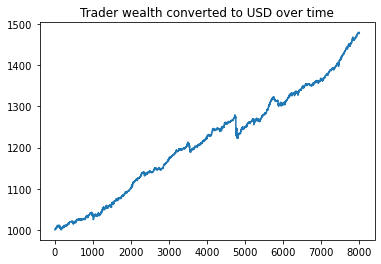

In [351]:
plt.plot(wealth_history)
plt.title("Trader wealth converted to USD over time")
plt.show()

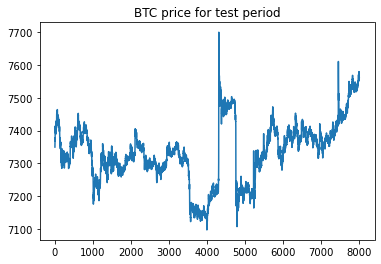

In [352]:
plt.plot(data_range)
plt.title("BTC price for test period")
plt.show()